In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import image
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.interpolation as interpolation

In [2]:
import datajoint as dj

In [3]:
schema = dj.schema('moire')

Connecting root@localhost:3306


In [4]:
@schema
class Source(dj.Lookup):
    definition = """
    name : char(12)
    ---
    image_url : varchar(255)
    """
    
    contents = (
        ('mona', 'https://upload.wikimedia.org/wikipedia/commons/5/55/Mona_Lisa_headcrop.jpg'),
        ('starry', 'https://upload.wikimedia.org/wikipedia/commons/f/f2/VangoghStarry-night2.jpg'),
        ('eye', 'https://upload.wikimedia.org/wikipedia/commons/4/42/GreenEye3.jpg'),
        ('sunflower', 'https://upload.wikimedia.org/wikipedia/commons/e/e5/Sonnenblume_Helianthus_1.JPG'),
        ('roma', 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Foro_di_Cesare_a_Roma.jpg/1024px-Foro_di_Cesare_a_Roma.jpg')
    )

In [5]:
import requests
import os

@schema
class Image(dj.Imported):
    definition = """
    -> Source
    ---
    image : longblob
    """
    
    def make(self, key):
        url = (Source & key).fetch1('image_url')
        tempfile = 'image.tmp'
        with open(tempfile, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, image=plt.imread(tempfile)))
        os.unlink(tempfile)

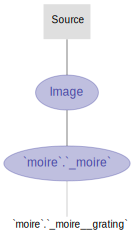

In [6]:
dj.Diagram(schema)

In [7]:
Image.populate()

In [15]:
@schema
class Moire(dj.Imported):
    definition = """
    -> Image
    ---
    period : float
    """
    
    class Grating(dj.Part):
        definition = """
        -> master
        grating_number : tinyint 
        ---
        grating_image : longblob
        
        """
    
    def make(self, key):
        
        def makeGrating(phaseImage):
            """ 
            Convert phaseImage into grating image scaled between 0 and 1
            """
            return 1/(1+np.exp(5*np.cos(2*np.pi*phaseImage)))

        img = (Image & key).fetch1('image')
        img = np.float64(img)/255.0;
        T = 1/40.
        carrier = np.stack(3*[
            np.outer(np.ones(img.shape[0]), 
                     np.linspace(0,1/T, img.shape[1]))], axis=-1)
        g1 = makeGrating(carrier-(1-img)/4)
        g2 = makeGrating(carrier+(1-img)/4)
        
        self.insert1(dict(key, period=T))
        self.Grating.insert1(dict(key, grating_number=1, grating_image=g1))
        self.Grating.insert1(dict(key, grating_number=2, grating_image=g2))

In [14]:
Moire.delete()

Deleting 10 rows from `moire`.`_moire__grating`
Deleting 15 rows from `moire`.`_moire`
Commit deletes? [yes, No]: yes
Deletes committed.


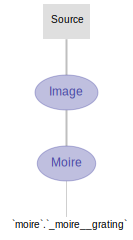

In [16]:
dj.Diagram(schema)


In [17]:
Moire.populate(display_progress=True)

Moire: 100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


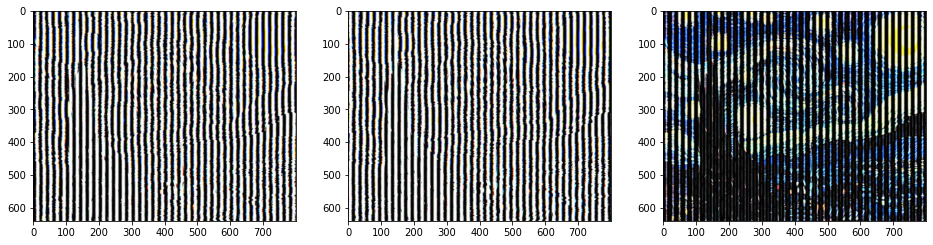

In [18]:
g1, g2 = (Moire.Grating & 'name="starry"').fetch("grating_image")
fig, ax = plt.subplots(1, 3, figsize=(16,6))
ax[0].imshow(g1)
ax[1].imshow(g2)
ax[2].imshow(g1*g2)